In [54]:
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import zipfile
import requests
from padelpy import padeldescriptor
import plotly.graph_objects as go
import plotly.express as px


# Bioinformathic and Cheminformatics Libs
from chembl_webresource_client import new_client
from rdkit import Chem, RDLogger
from rdkit.Chem import RDConfig
from rdkit.Chem import AllChem
from rdkit.Chem import Draw
from rdkit.Chem import Descriptors
from rdkit.Chem import PandasTools
from chembl_webresource_client.new_client import new_client
# import rdkit library
from rdkit import Chem
from rdkit.Chem import Descriptors, Lipinski
from rdkit.Chem.Descriptors import ExactMolWt
#  Fingerprints of PaDEL
import glob
from padelpy import padeldescriptor
import glob
# for model
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


# Data Collection

In [55]:
# Search for the coronavirus target

target = new_client.target
target_query = target.search('Proteases')
targets = pd.DataFrame.from_dict(target_query)
targets

,cross_references,organism,pref_name,score,species_group_flag,target_chembl_id,target_components,target_type,tax_id
0,[],Human T-lymphotropic virus 1,Protease,6.0,False,CHEMBL5297,"[{'accession': 'Q82323', 'component_descriptio...",SINGLE PROTEIN,11908
1,[],Human immunodeficiency virus 1,Protease,6.0,False,CHEMBL2366517,"[{'accession': 'Q9YQ12', 'component_descriptio...",SINGLE PROTEIN,11676
2,[],Norovirus Hu/GII.4-2002/WeertE022/2002/NL,Protease,6.0,False,CHEMBL4295547,"[{'accession': 'G1FEK8', 'component_descriptio...",SINGLE PROTEIN,1070539
3,[],Human T-cell leukemia virus type I,Protease,6.0,False,CHEMBL4296327,"[{'accession': 'Q82134', 'component_descriptio...",SINGLE PROTEIN,11908
4,[],Homo sapiens,Trypsin I,5.0,False,CHEMBL209,"[{'accession': 'P07477', 'component_descriptio...",SINGLE PROTEIN,9606
...,...,...,...,...,...,...,...,...,...
714,[],Homo sapiens,Prothrombinase complex,2.0,False,CHEMBL5482991,"[{'accession': 'P00742', 'component_descriptio...",PROTEIN COMPLEX,9606
715,[],Homo sapiens,Amyloid-beta A4 protein,1.0,False,CHEMBL2487,"[{'accession': 'P05067', 'component_descriptio...",SINGLE PROTEIN,9606
716,[],Severe acute respiratory syndrome-related coro...,Replicase polyprotein 1ab,1.0,False,CHEMBL5118,"[{'accession': 'P0C6X7', 'component_descriptio...",SINGLE PROTEIN,694009
717,[],Homo sapiens,Gamma-secretase,1.0,False,CHEMBL2094135,"[{'accession': 'Q96BI3', 'component_descriptio...",PROTEIN COMPLEX,9606


In [56]:
selected_target = targets.target_chembl_id[1]
selected_target

'CHEMBL2366517'

# We apply a filter to retrieve only bioactivity data for CHEMBL4295830 that are reported as IC-50 values in nM (nanomolar) unit.
#### ****

In [57]:
activity = new_client.activity
res = activity.filter(target_chembl_id=selected_target).filter(standard_type="IC50")

In [58]:
df = pd.DataFrame.from_dict(res)
df.head()

,action_type,activity_comment,activity_id,activity_properties,assay_chembl_id,assay_description,assay_type,assay_variant_accession,assay_variant_mutation,bao_endpoint,...,target_organism,target_pref_name,target_tax_id,text_value,toid,type,units,uo_units,upper_value,value
0,None,None,1985918,[],CHEMBL899796,Inhibition of HIV1 recombinant protease,B,None,None,BAO_0000190,...,Human immunodeficiency virus 1,Protease,11676,None,None,IC50,nM,UO_0000065,None,21.1
1,None,None,1985919,[],CHEMBL899796,Inhibition of HIV1 recombinant protease,B,None,None,BAO_0000190,...,Human immunodeficiency virus 1,Protease,11676,None,None,IC50,nM,UO_0000065,None,153.9
2,None,None,1985920,[],CHEMBL899796,Inhibition of HIV1 recombinant protease,B,None,None,BAO_0000190,...,Human immunodeficiency virus 1,Protease,11676,None,None,IC50,nM,UO_0000065,None,37.3
3,None,None,1985921,[],CHEMBL899796,Inhibition of HIV1 recombinant protease,B,None,None,BAO_0000190,...,Human immunodeficiency virus 1,Protease,11676,None,None,IC50,nM,UO_0000065,None,2.5
4,None,None,1985922,[],CHEMBL899796,Inhibition of HIV1 recombinant protease,B,None,None,BAO_0000190,...,Human immunodeficiency virus 1,Protease,11676,None,None,IC50,nM,UO_0000065,None,10000.0


## Data Preprocessing
- *Data Preparation & Data Cleaning*
- *EDA*
- *Feature Engineering*
- *Building Models*
- *Model evaluation & Creat metrics*


In [59]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 885 entries, 0 to 884
Data columns (total 46 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   action_type                0 non-null      object
 1   activity_comment           21 non-null     object
 2   activity_id                885 non-null    int64 
 3   activity_properties        885 non-null    object
 4   assay_chembl_id            885 non-null    object
 5   assay_description          885 non-null    object
 6   assay_type                 885 non-null    object
 7   assay_variant_accession    12 non-null     object
 8   assay_variant_mutation     12 non-null     object
 9   bao_endpoint               885 non-null    object
 10  bao_format                 885 non-null    object
 11  bao_label                  885 non-null    object
 12  canonical_smiles           885 non-null    object
 13  data_validity_comment      53 non-null     object
 14  data_valid

In [60]:
df.dtypes

action_type                  object
activity_comment             object
activity_id                   int64
activity_properties          object
assay_chembl_id              object
assay_description            object
assay_type                   object
assay_variant_accession      object
assay_variant_mutation       object
bao_endpoint                 object
bao_format                   object
bao_label                    object
canonical_smiles             object
data_validity_comment        object
data_validity_description    object
document_chembl_id           object
document_journal             object
document_year                 int64
ligand_efficiency            object
molecule_chembl_id           object
molecule_pref_name           object
parent_molecule_chembl_id    object
pchembl_value                object
potential_duplicate           int64
qudt_units                   object
record_id                     int64
relation                     object
src_id                      

In [61]:
df.shape

(885, 46)

In [62]:
df.size

40710

In [63]:
df.columns

Index(['action_type', 'activity_comment', 'activity_id', 'activity_properties',
       'assay_chembl_id', 'assay_description', 'assay_type',
       'assay_variant_accession', 'assay_variant_mutation', 'bao_endpoint',
       'bao_format', 'bao_label', 'canonical_smiles', 'data_validity_comment',
       'data_validity_description', 'document_chembl_id', 'document_journal',
       'document_year', 'ligand_efficiency', 'molecule_chembl_id',
       'molecule_pref_name', 'parent_molecule_chembl_id', 'pchembl_value',
       'potential_duplicate', 'qudt_units', 'record_id', 'relation', 'src_id',
       'standard_flag', 'standard_relation', 'standard_text_value',
       'standard_type', 'standard_units', 'standard_upper_value',
       'standard_value', 'target_chembl_id', 'target_organism',
       'target_pref_name', 'target_tax_id', 'text_value', 'toid', 'type',
       'units', 'uo_units', 'upper_value', 'value'],
      dtype='object')

In [64]:
df.to_csv('Proteases.csv',index=False)

In [65]:
df_last=df
df_last.sample(4)

,action_type,activity_comment,activity_id,activity_properties,assay_chembl_id,assay_description,assay_type,assay_variant_accession,assay_variant_mutation,bao_endpoint,...,target_organism,target_pref_name,target_tax_id,text_value,toid,type,units,uo_units,upper_value,value
504,None,None,15064275,[],CHEMBL3368173,Inhibition of HIV-1 protease using DABCYL-Abu-...,B,None,None,BAO_0000190,...,Human immunodeficiency virus 1,Protease,11676,None,None,IC50,uM,UO_0000065,None,1.5
732,None,None,18974916,[],CHEMBL4337972,Inhibition of HIV1 protease expressed in Esche...,B,None,None,BAO_0000190,...,Human immunodeficiency virus 1,Protease,11676,None,None,IC50,uM,UO_0000065,None,50.0
370,None,None,13844745,[],CHEMBL3094814,Inhibition of HIV-1 NL4-3 wild type protease e...,B,None,None,BAO_0000190,...,Human immunodeficiency virus 1,Protease,11676,None,None,IC50,nM,UO_0000065,None,30.7
568,None,None,16572608,[],CHEMBL3802587,Inhibition of HIV1 protease using Pr SF-2-WTQ7...,B,None,None,BAO_0000190,...,Human immunodeficiency virus 1,Protease,11676,None,None,IC50,uM,UO_0000065,None,100.0


# Cleaning

#### Check For Missing Data

In [66]:
df_last.isna().sum()

action_type                  885
activity_comment             864
activity_id                    0
activity_properties            0
assay_chembl_id                0
assay_description              0
assay_type                     0
assay_variant_accession      873
assay_variant_mutation       873
bao_endpoint                   0
bao_format                     0
bao_label                      0
canonical_smiles               0
data_validity_comment        832
data_validity_description    832
document_chembl_id             0
document_journal               3
document_year                  0
ligand_efficiency            266
molecule_chembl_id             0
molecule_pref_name           809
parent_molecule_chembl_id      0
pchembl_value                266
potential_duplicate            0
qudt_units                    18
record_id                      0
relation                      18
src_id                         0
standard_flag                  0
standard_relation             18
standard_t

#### Drop Coll That have Missing values

In [67]:
columns_to_drop = [
    'action_type',
    'activity_comment',
    'assay_variant_accession',
    'assay_variant_mutation',
    'data_validity_comment',
    'data_validity_description',
    'molecule_pref_name',
    'standard_text_value',
    'standard_upper_value',
    'text_value',
    'toid','ligand_efficiency',
    'upper_value'
]

# Drop the columns from the DataFrame
df_last = df_last.drop(labels=columns_to_drop, axis=1)

In [68]:
df_last.dropna(inplace=True,axis=0)

In [69]:
df_last.isna().sum()

activity_id                  0
activity_properties          0
assay_chembl_id              0
assay_description            0
assay_type                   0
bao_endpoint                 0
bao_format                   0
bao_label                    0
canonical_smiles             0
document_chembl_id           0
document_journal             0
document_year                0
molecule_chembl_id           0
parent_molecule_chembl_id    0
pchembl_value                0
potential_duplicate          0
qudt_units                   0
record_id                    0
relation                     0
src_id                       0
standard_flag                0
standard_relation            0
standard_type                0
standard_units               0
standard_value               0
target_chembl_id             0
target_organism              0
target_pref_name             0
target_tax_id                0
type                         0
units                        0
uo_units                     0
value   

In [70]:
# Remove the duplicated rows
df3 = df_last.drop_duplicates(['canonical_smiles'])
df3

,activity_id,activity_properties,assay_chembl_id,assay_description,assay_type,bao_endpoint,bao_format,bao_label,canonical_smiles,document_chembl_id,...,standard_units,standard_value,target_chembl_id,target_organism,target_pref_name,target_tax_id,type,units,uo_units,value
0,1985918,[],CHEMBL899796,Inhibition of HIV1 recombinant protease,B,BAO_0000190,BAO_0000357,single protein format,O=C(N[C@@H]1c2ccccc2C[C@@H]1O)[C@@H](Cc1ccccc1...,CHEMBL1137472,...,nM,21.1,CHEMBL2366517,Human immunodeficiency virus 1,Protease,11676,IC50,nM,UO_0000065,21.1
1,1985919,[],CHEMBL899796,Inhibition of HIV1 recombinant protease,B,BAO_0000190,BAO_0000357,single protein format,N=[S+]([O-])([C@H](Cc1ccccc1)C(=O)N[C@H]1c2ccc...,CHEMBL1137472,...,nM,153.9,CHEMBL2366517,Human immunodeficiency virus 1,Protease,11676,IC50,nM,UO_0000065,153.9
2,1985920,[],CHEMBL899796,Inhibition of HIV1 recombinant protease,B,BAO_0000190,BAO_0000357,single protein format,N=[S+]([O-])([C@H](Cc1ccccc1)C(=O)N[C@H]1c2ccc...,CHEMBL1137472,...,nM,37.3,CHEMBL2366517,Human immunodeficiency virus 1,Protease,11676,IC50,nM,UO_0000065,37.3
3,1985921,[],CHEMBL899796,Inhibition of HIV1 recombinant protease,B,BAO_0000190,BAO_0000357,single protein format,N=[S+]([O-])(C[C@H](Cc1ccccc1)C(=O)N[C@@H]1c2c...,CHEMBL1137472,...,nM,2.5,CHEMBL2366517,Human immunodeficiency virus 1,Protease,11676,IC50,nM,UO_0000065,2.5
5,1985923,[],CHEMBL899796,Inhibition of HIV1 recombinant protease,B,BAO_0000190,BAO_0000357,single protein format,O=C(N[C@H]1c2ccccc2C[C@H]1O)[C@H](Cc1ccccc1)C[...,CHEMBL1137472,...,nM,53.1,CHEMBL2366517,Human immunodeficiency virus 1,Protease,11676,IC50,nM,UO_0000065,53.1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
880,19207212,[],CHEMBL4392471,Inhibition of HIV1 protease activity,B,BAO_0000190,BAO_0000357,single protein format,COC(=O)N[C@H](C(=O)N[C@@H](Cc1ccccc1)[C@H](CN(...,CHEMBL4390686,...,nM,4.0,CHEMBL2366517,Human immunodeficiency virus 1,Protease,11676,IC50,nM,UO_0000065,4.0
881,19207213,[],CHEMBL4392471,Inhibition of HIV1 protease activity,B,BAO_0000190,BAO_0000357,single protein format,COC(=O)N[C@H](C(=O)N[C@@H](Cc1ccccc1)[C@H](CN(...,CHEMBL4390686,...,nM,4.0,CHEMBL2366517,Human immunodeficiency virus 1,Protease,11676,IC50,nM,UO_0000065,4.0
882,19207214,[],CHEMBL4392471,Inhibition of HIV1 protease activity,B,BAO_0000190,BAO_0000357,single protein format,COC(=O)N[C@H](C(=O)N[C@@H](Cc1ccccc1)[C@H](CN(...,CHEMBL4390686,...,nM,4.0,CHEMBL2366517,Human immunodeficiency virus 1,Protease,11676,IC50,nM,UO_0000065,4.0
883,19207215,[],CHEMBL4392471,Inhibition of HIV1 protease activity,B,BAO_0000190,BAO_0000357,single protein format,COC(=O)N[C@H](C(=O)N[C@@H](Cc1ccccc1)[C@H](CN(...,CHEMBL4390686,...,nM,4.0,CHEMBL2366517,Human immunodeficiency virus 1,Protease,11676,IC50,nM,UO_0000065,4.0


### Display Data After Cleaning

In [71]:
df3.head()

,activity_id,activity_properties,assay_chembl_id,assay_description,assay_type,bao_endpoint,bao_format,bao_label,canonical_smiles,document_chembl_id,...,standard_units,standard_value,target_chembl_id,target_organism,target_pref_name,target_tax_id,type,units,uo_units,value
0,1985918,[],CHEMBL899796,Inhibition of HIV1 recombinant protease,B,BAO_0000190,BAO_0000357,single protein format,O=C(N[C@@H]1c2ccccc2C[C@@H]1O)[C@@H](Cc1ccccc1...,CHEMBL1137472,...,nM,21.1,CHEMBL2366517,Human immunodeficiency virus 1,Protease,11676,IC50,nM,UO_0000065,21.1
1,1985919,[],CHEMBL899796,Inhibition of HIV1 recombinant protease,B,BAO_0000190,BAO_0000357,single protein format,N=[S+]([O-])([C@H](Cc1ccccc1)C(=O)N[C@H]1c2ccc...,CHEMBL1137472,...,nM,153.9,CHEMBL2366517,Human immunodeficiency virus 1,Protease,11676,IC50,nM,UO_0000065,153.9
2,1985920,[],CHEMBL899796,Inhibition of HIV1 recombinant protease,B,BAO_0000190,BAO_0000357,single protein format,N=[S+]([O-])([C@H](Cc1ccccc1)C(=O)N[C@H]1c2ccc...,CHEMBL1137472,...,nM,37.3,CHEMBL2366517,Human immunodeficiency virus 1,Protease,11676,IC50,nM,UO_0000065,37.3
3,1985921,[],CHEMBL899796,Inhibition of HIV1 recombinant protease,B,BAO_0000190,BAO_0000357,single protein format,N=[S+]([O-])(C[C@H](Cc1ccccc1)C(=O)N[C@@H]1c2c...,CHEMBL1137472,...,nM,2.5,CHEMBL2366517,Human immunodeficiency virus 1,Protease,11676,IC50,nM,UO_0000065,2.5
5,1985923,[],CHEMBL899796,Inhibition of HIV1 recombinant protease,B,BAO_0000190,BAO_0000357,single protein format,O=C(N[C@H]1c2ccccc2C[C@H]1O)[C@H](Cc1ccccc1)C[...,CHEMBL1137472,...,nM,53.1,CHEMBL2366517,Human immunodeficiency virus 1,Protease,11676,IC50,nM,UO_0000065,53.1


### Select Only Important Features

In [72]:
# Keeping only the required features : 'molecule_chembl_id','canonical_smiles','standard_value'
selection = ['molecule_chembl_id','canonical_smiles','standard_value']
df4= df3[selection]
df4

,molecule_chembl_id,canonical_smiles,standard_value
0,CHEMBL1627209,O=C(N[C@@H]1c2ccccc2C[C@@H]1O)[C@@H](Cc1ccccc1...,21.1
1,CHEMBL1627287,N=[S+]([O-])([C@H](Cc1ccccc1)C(=O)N[C@H]1c2ccc...,153.9
2,CHEMBL1627235,N=[S+]([O-])([C@H](Cc1ccccc1)C(=O)N[C@H]1c2ccc...,37.3
3,CHEMBL1627210,N=[S+]([O-])(C[C@H](Cc1ccccc1)C(=O)N[C@@H]1c2c...,2.5
5,CHEMBL396813,O=C(N[C@H]1c2ccccc2C[C@H]1O)[C@H](Cc1ccccc1)C[...,53.1
...,...,...,...
880,CHEMBL4525849,COC(=O)N[C@H](C(=O)N[C@@H](Cc1ccccc1)[C@H](CN(...,4.0
881,CHEMBL4542773,COC(=O)N[C@H](C(=O)N[C@@H](Cc1ccccc1)[C@H](CN(...,4.0
882,CHEMBL4573907,COC(=O)N[C@H](C(=O)N[C@@H](Cc1ccccc1)[C@H](CN(...,4.0
883,CHEMBL4574382,COC(=O)N[C@H](C(=O)N[C@@H](Cc1ccccc1)[C@H](CN(...,4.0


# Save the preprocessed dataset to a CSV

In [73]:
df4.to_csv('Proteases_data_preprocessed.csv', index=False)

### encode the standard_value column by class

In [74]:
def activity_classifier(sv):

    if float(sv) >= 10000:
        return "inactive"
    elif float(sv) <= 1000:
        return "active"
    else:
        return "intermediate"

In [75]:
# Create new column named "bio_class" & Apply the function to the dataset (to the standard_value column)
df4['bio_class'] = df4['standard_value'].apply(activity_classifier)
df4

C:\Users\Administrator\AppData\Local\Temp\ipykernel_8444\3631790328.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,molecule_chembl_id,canonical_smiles,standard_value,bio_class
0,CHEMBL1627209,O=C(N[C@@H]1c2ccccc2C[C@@H]1O)[C@@H](Cc1ccccc1...,21.1,active
1,CHEMBL1627287,N=[S+]([O-])([C@H](Cc1ccccc1)C(=O)N[C@H]1c2ccc...,153.9,active
2,CHEMBL1627235,N=[S+]([O-])([C@H](Cc1ccccc1)C(=O)N[C@H]1c2ccc...,37.3,active
3,CHEMBL1627210,N=[S+]([O-])(C[C@H](Cc1ccccc1)C(=O)N[C@@H]1c2c...,2.5,active
5,CHEMBL396813,O=C(N[C@H]1c2ccccc2C[C@H]1O)[C@H](Cc1ccccc1)C[...,53.1,active
...,...,...,...,...
880,CHEMBL4525849,COC(=O)N[C@H](C(=O)N[C@@H](Cc1ccccc1)[C@H](CN(...,4.0,active
881,CHEMBL4542773,COC(=O)N[C@H](C(=O)N[C@@H](Cc1ccccc1)[C@H](CN(...,4.0,active
882,CHEMBL4573907,COC(=O)N[C@H](C(=O)N[C@@H](Cc1ccccc1)[C@H](CN(...,4.0,active
883,CHEMBL4574382,COC(=O)N[C@H](C(=O)N[C@@H](Cc1ccccc1)[C@H](CN(...,4.0,active


In [76]:
# Save the encoded dataset to a CSV file bioactivity_data_encoded.csv
df4.to_csv('Proteases_data_encoded.csv', index=False)

# Calculating Lipinski descriptors

### Load Data After Encode

In [77]:
df5=pd.read_csv('Proteases_data_encoded.csv')

In [78]:
df5.head()

,molecule_chembl_id,canonical_smiles,standard_value,bio_class
0,CHEMBL1627209,O=C(N[C@@H]1c2ccccc2C[C@@H]1O)[C@@H](Cc1ccccc1...,21.1,active
1,CHEMBL1627287,N=[S+]([O-])([C@H](Cc1ccccc1)C(=O)N[C@H]1c2ccc...,153.9,active
2,CHEMBL1627235,N=[S+]([O-])([C@H](Cc1ccccc1)C(=O)N[C@H]1c2ccc...,37.3,active
3,CHEMBL1627210,N=[S+]([O-])(C[C@H](Cc1ccccc1)C(=O)N[C@@H]1c2c...,2.5,active
4,CHEMBL396813,O=C(N[C@H]1c2ccccc2C[C@H]1O)[C@H](Cc1ccccc1)C[...,53.1,active


# Calculate the Lipinski descreptors using rdkit library


In [79]:

df5['smiles_mol'] = df5['canonical_smiles'].apply(Chem.MolFromSmiles)

df5['MW'] = df5['smiles_mol'].apply(Descriptors.MolWt)
df5['LogP'] = df5['smiles_mol'].apply(Descriptors.MolLogP)
df5['NumHDonors'] = df5['smiles_mol'].apply(Lipinski.NumHDonors)
df5['NumHAcceptors'] = df5['smiles_mol'].apply(Lipinski.NumHAcceptors)
df5.head()

,molecule_chembl_id,canonical_smiles,standard_value,bio_class,smiles_mol,MW,LogP,NumHDonors,NumHAcceptors
0,CHEMBL1627209,O=C(N[C@@H]1c2ccccc2C[C@@H]1O)[C@@H](Cc1ccccc1...,21.1,active,<rdkit.Chem.rdchem.Mol object at 0x000001FE88D...,636.814,4.00190,4,5
1,CHEMBL1627287,N=[S+]([O-])([C@H](Cc1ccccc1)C(=O)N[C@H]1c2ccc...,153.9,active,<rdkit.Chem.rdchem.Mol object at 0x000001FE88D...,623.775,3.80477,5,6
2,CHEMBL1627235,N=[S+]([O-])([C@H](Cc1ccccc1)C(=O)N[C@H]1c2ccc...,37.3,active,<rdkit.Chem.rdchem.Mol object at 0x000001FE88D...,623.775,3.80477,5,6
3,CHEMBL1627210,N=[S+]([O-])(C[C@H](Cc1ccccc1)C(=O)N[C@@H]1c2c...,2.5,active,<rdkit.Chem.rdchem.Mol object at 0x000001FE88D...,651.829,4.29997,5,6
4,CHEMBL396813,O=C(N[C@H]1c2ccccc2C[C@H]1O)[C@H](Cc1ccccc1)C[...,53.1,active,<rdkit.Chem.rdchem.Mol object at 0x000001FE8C5...,636.814,4.00190,4,5


In [80]:
# Remove the column smiles_mol used to calculate descriptors
df5 = df5.drop('smiles_mol', axis=1)
df5

,molecule_chembl_id,canonical_smiles,standard_value,bio_class,MW,LogP,NumHDonors,NumHAcceptors
0,CHEMBL1627209,O=C(N[C@@H]1c2ccccc2C[C@@H]1O)[C@@H](Cc1ccccc1...,21.1,active,636.814,4.00190,4,5
1,CHEMBL1627287,N=[S+]([O-])([C@H](Cc1ccccc1)C(=O)N[C@H]1c2ccc...,153.9,active,623.775,3.80477,5,6
2,CHEMBL1627235,N=[S+]([O-])([C@H](Cc1ccccc1)C(=O)N[C@H]1c2ccc...,37.3,active,623.775,3.80477,5,6
3,CHEMBL1627210,N=[S+]([O-])(C[C@H](Cc1ccccc1)C(=O)N[C@@H]1c2c...,2.5,active,651.829,4.29997,5,6
4,CHEMBL396813,O=C(N[C@H]1c2ccccc2C[C@H]1O)[C@H](Cc1ccccc1)C[...,53.1,active,636.814,4.00190,4,5
...,...,...,...,...,...,...,...,...
534,CHEMBL4525849,COC(=O)N[C@H](C(=O)N[C@@H](Cc1ccccc1)[C@H](CN(...,4.0,active,775.948,4.10970,5,11
535,CHEMBL4542773,COC(=O)N[C@H](C(=O)N[C@@H](Cc1ccccc1)[C@H](CN(...,4.0,active,775.948,4.10970,5,11
536,CHEMBL4573907,COC(=O)N[C@H](C(=O)N[C@@H](Cc1ccccc1)[C@H](CN(...,4.0,active,852.046,5.33250,5,11
537,CHEMBL4574382,COC(=O)N[C@H](C(=O)N[C@@H](Cc1ccccc1)[C@H](CN(...,4.0,active,852.046,5.33250,5,11


# To convert any SMILE into 2D molecule


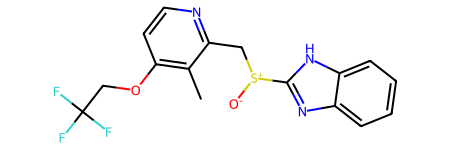

In [81]:
mol = Chem.MolFromSmiles('Cc1c(OCC(F)(F)F)ccnc1C[S+]([O-])c1nc2ccccc2[nH]1')
mol

# **. Exploratory Data Analysis (EDA)**

In [82]:
import plotly.subplots as sp
import plotly as px
import plotly.graph_objects as go
import math

# Create a 4x4 grid for subplots (adjust as needed for the number of features)
features = ["standard_value", "MW", "LogP", "NumHDonors", "NumHAcceptors"]
num_features = len(features)
grid_size = math.ceil(math.sqrt(num_features))
fig = sp.make_subplots(
    rows=grid_size, 
    cols=grid_size, 
    subplot_titles=features, 
    horizontal_spacing=0.2, 
    vertical_spacing=0.2
)

# Add scatter plots for each feature
for idx, feature in enumerate(features):
    row = idx // grid_size + 1
    col = idx % grid_size + 1
    for bio_class in df5["bio_class"].unique():
        filtered_df = df5[df5["bio_class"] == bio_class]
        fig.add_trace(
            go.Scatter(
                x=filtered_df[feature],
                y=filtered_df["bio_class"],
                mode="markers",
                name=bio_class,
                marker=dict(size=10, opacity=0.7)
            ),
            row=row,
            col=col
        )

# Update layout with dark theme and spacing adjustments
fig.update_layout(
    height=700,
    width=1100,
    showlegend=True,
    template="plotly_dark",
    title="Scatter Plots for Features vs Bio Class",
)

# Update x-axis and y-axis titles for each subplot
for i, feature in enumerate(features):
    fig.update_xaxes(title_text=feature, row=(i // grid_size) + 1, col=(i % grid_size) + 1)
    fig.update_yaxes(title_text="Bio Class", row=(i // grid_size) + 1, col=(i % grid_size) + 1)

# Show the figure
fig.show()

In [83]:
# Drop the "intermediate" class
df6= df5[df5.bio_class != 'intermediate']
df6

,molecule_chembl_id,canonical_smiles,standard_value,bio_class,MW,LogP,NumHDonors,NumHAcceptors
0,CHEMBL1627209,O=C(N[C@@H]1c2ccccc2C[C@@H]1O)[C@@H](Cc1ccccc1...,21.1,active,636.814,4.00190,4,5
1,CHEMBL1627287,N=[S+]([O-])([C@H](Cc1ccccc1)C(=O)N[C@H]1c2ccc...,153.9,active,623.775,3.80477,5,6
2,CHEMBL1627235,N=[S+]([O-])([C@H](Cc1ccccc1)C(=O)N[C@H]1c2ccc...,37.3,active,623.775,3.80477,5,6
3,CHEMBL1627210,N=[S+]([O-])(C[C@H](Cc1ccccc1)C(=O)N[C@@H]1c2c...,2.5,active,651.829,4.29997,5,6
4,CHEMBL396813,O=C(N[C@H]1c2ccccc2C[C@H]1O)[C@H](Cc1ccccc1)C[...,53.1,active,636.814,4.00190,4,5
...,...,...,...,...,...,...,...,...
534,CHEMBL4525849,COC(=O)N[C@H](C(=O)N[C@@H](Cc1ccccc1)[C@H](CN(...,4.0,active,775.948,4.10970,5,11
535,CHEMBL4542773,COC(=O)N[C@H](C(=O)N[C@@H](Cc1ccccc1)[C@H](CN(...,4.0,active,775.948,4.10970,5,11
536,CHEMBL4573907,COC(=O)N[C@H](C(=O)N[C@@H](Cc1ccccc1)[C@H](CN(...,4.0,active,852.046,5.33250,5,11
537,CHEMBL4574382,COC(=O)N[C@H](C(=O)N[C@@H](Cc1ccccc1)[C@H](CN(...,4.0,active,852.046,5.33250,5,11


# The countplot for the 2 bioclasses


In [84]:
import plotly.express as px

# Create a countplot using Plotly
fig = px.bar(
    df6,
    y='bio_class',
    color='bio_class',
    title='Bioactivity Class Frequency',
    labels={'bio_class': 'Bioactivity Class', 'count': 'Frequency'},
    template='plotly_dark'
)

# Update layout for better readability
fig.update_layout(
    height=400,
    width=1100,
    xaxis_title='Bioactivity Class',
    yaxis_title='Frequency',
    font=dict(size=14, family='Arial'),
    showlegend=False
)

# Show the bar plot
fig.show()

In [85]:
import plotly.express as px

# Create a pair plot using Plotly
fig = px.scatter_matrix(
    df5,
    dimensions=["standard_value", "MW", "LogP", "NumHDonors", "NumHAcceptors"],
    color="bio_class",
    title="Pairplot of Bio Class",
    labels={col: col.replace('_', ' ') for col in df5.columns},
    template="plotly_dark"
)

# Update layout for better readability
fig.update_layout(
    height=800,
    width=1100,
    showlegend=True
)

# Show the pair plot
fig.show()


In [86]:
df6.info()

<class 'pandas.core.frame.DataFrame'>
Index: 425 entries, 0 to 538
Data columns (total 8 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   molecule_chembl_id  425 non-null    object 
 1   canonical_smiles    425 non-null    object 
 2   standard_value      425 non-null    float64
 3   bio_class           425 non-null    object 
 4   MW                  425 non-null    float64
 5   LogP                425 non-null    float64
 6   NumHDonors          425 non-null    int64  
 7   NumHAcceptors       425 non-null    int64  
dtypes: float64(3), int64(2), object(3)
memory usage: 29.9+ KB


# **Convert IC50 to pIC50**

### Values greater than 100,000,000 will be fixed at 100,000,000 otherwise the negative logarithmic value will become negative.


In [87]:
def norm_value(input):
  norm = []

  for i in input ['standard_value']:
    if i > 100000000:
      i = 100000000
    norm.append(i)

  input ['standard_value_norm'] = norm
  x = input.drop ('standard_value', axis=1)

  return x

In [88]:
df7 =norm_value(df6)
df7

C:\Users\Administrator\AppData\Local\Temp\ipykernel_8444\2940245756.py:9: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,molecule_chembl_id,canonical_smiles,bio_class,MW,LogP,NumHDonors,NumHAcceptors,standard_value_norm
0,CHEMBL1627209,O=C(N[C@@H]1c2ccccc2C[C@@H]1O)[C@@H](Cc1ccccc1...,active,636.814,4.00190,4,5,21.1
1,CHEMBL1627287,N=[S+]([O-])([C@H](Cc1ccccc1)C(=O)N[C@H]1c2ccc...,active,623.775,3.80477,5,6,153.9
2,CHEMBL1627235,N=[S+]([O-])([C@H](Cc1ccccc1)C(=O)N[C@H]1c2ccc...,active,623.775,3.80477,5,6,37.3
3,CHEMBL1627210,N=[S+]([O-])(C[C@H](Cc1ccccc1)C(=O)N[C@@H]1c2c...,active,651.829,4.29997,5,6,2.5
4,CHEMBL396813,O=C(N[C@H]1c2ccccc2C[C@H]1O)[C@H](Cc1ccccc1)C[...,active,636.814,4.00190,4,5,53.1
...,...,...,...,...,...,...,...,...
534,CHEMBL4525849,COC(=O)N[C@H](C(=O)N[C@@H](Cc1ccccc1)[C@H](CN(...,active,775.948,4.10970,5,11,4.0
535,CHEMBL4542773,COC(=O)N[C@H](C(=O)N[C@@H](Cc1ccccc1)[C@H](CN(...,active,775.948,4.10970,5,11,4.0
536,CHEMBL4573907,COC(=O)N[C@H](C(=O)N[C@@H](Cc1ccccc1)[C@H](CN(...,active,852.046,5.33250,5,11,4.0
537,CHEMBL4574382,COC(=O)N[C@H](C(=O)N[C@@H](Cc1ccccc1)[C@H](CN(...,active,852.046,5.33250,5,11,4.0


#### To allow IC50 data to be more uniformly distributed, we will convert IC50 to pIC50=-log10(IC50).


In [89]:
def pIC50(input):
    pIC50 = []

    for i in input['standard_value_norm']:
      # Converts nM to M
        molar = i*(10**-9)
        pIC50.append(-np.log10(molar))

    input['pIC50'] = pIC50
    x = input.drop('standard_value_norm', axis=1)

    return x

In [90]:
df8= pIC50(df7)
df8

,molecule_chembl_id,canonical_smiles,bio_class,MW,LogP,NumHDonors,NumHAcceptors,pIC50
0,CHEMBL1627209,O=C(N[C@@H]1c2ccccc2C[C@@H]1O)[C@@H](Cc1ccccc1...,active,636.814,4.00190,4,5,7.675718
1,CHEMBL1627287,N=[S+]([O-])([C@H](Cc1ccccc1)C(=O)N[C@H]1c2ccc...,active,623.775,3.80477,5,6,6.812761
2,CHEMBL1627235,N=[S+]([O-])([C@H](Cc1ccccc1)C(=O)N[C@H]1c2ccc...,active,623.775,3.80477,5,6,7.428291
3,CHEMBL1627210,N=[S+]([O-])(C[C@H](Cc1ccccc1)C(=O)N[C@@H]1c2c...,active,651.829,4.29997,5,6,8.602060
4,CHEMBL396813,O=C(N[C@H]1c2ccccc2C[C@H]1O)[C@H](Cc1ccccc1)C[...,active,636.814,4.00190,4,5,7.274905
...,...,...,...,...,...,...,...,...
534,CHEMBL4525849,COC(=O)N[C@H](C(=O)N[C@@H](Cc1ccccc1)[C@H](CN(...,active,775.948,4.10970,5,11,8.397940
535,CHEMBL4542773,COC(=O)N[C@H](C(=O)N[C@@H](Cc1ccccc1)[C@H](CN(...,active,775.948,4.10970,5,11,8.397940
536,CHEMBL4573907,COC(=O)N[C@H](C(=O)N[C@@H](Cc1ccccc1)[C@H](CN(...,active,852.046,5.33250,5,11,8.397940
537,CHEMBL4574382,COC(=O)N[C@H](C(=O)N[C@@H](Cc1ccccc1)[C@H](CN(...,active,852.046,5.33250,5,11,8.397940


# save the dataset in a csv file

In [91]:

df8.to_csv('df_pic50.csv', index=False)

In [92]:
import plotly.subplots as sp
import plotly.graph_objects as go

# Create a subplot for boxplots of each feature against bio_class
features = ['standard_value', 'MW', 'LogP', 'NumHDonors', 'NumHAcceptors']
fig = sp.make_subplots(rows=2, cols=2, subplot_titles=features[:4])

# Add boxplots for the first 4 features
for i, feature in enumerate(features[:4]):
    row = i // 2 + 1
    col = i % 2 + 1
    fig.add_trace(
        go.Box(
            x=df6['bio_class'],
            y=df6[feature],
            name=feature,
            boxmean=True
        ),
        row=row,
        col=col
    )

# Update layout with dark theme and spacing adjustments
fig.update_layout(
    height=800,
    width=1100,
    template="plotly_dark",
    title="Boxplots of Features by Bio Class",
    showlegend=False
)

# Update x-axis and y-axis titles
fig.update_xaxes(title_text="Bioactivity Class")
fig.update_yaxes(title_text="Feature Value")

# Show the figure
fig.show()


# **Calculating fingerprint descriptors (using PaDEL descriptors)**

In [93]:
df9=pd.read_csv('df_pic50.csv')
df9

,molecule_chembl_id,canonical_smiles,bio_class,MW,LogP,NumHDonors,NumHAcceptors,pIC50
0,CHEMBL1627209,O=C(N[C@@H]1c2ccccc2C[C@@H]1O)[C@@H](Cc1ccccc1...,active,636.814,4.00190,4,5,7.675718
1,CHEMBL1627287,N=[S+]([O-])([C@H](Cc1ccccc1)C(=O)N[C@H]1c2ccc...,active,623.775,3.80477,5,6,6.812761
2,CHEMBL1627235,N=[S+]([O-])([C@H](Cc1ccccc1)C(=O)N[C@H]1c2ccc...,active,623.775,3.80477,5,6,7.428291
3,CHEMBL1627210,N=[S+]([O-])(C[C@H](Cc1ccccc1)C(=O)N[C@@H]1c2c...,active,651.829,4.29997,5,6,8.602060
4,CHEMBL396813,O=C(N[C@H]1c2ccccc2C[C@H]1O)[C@H](Cc1ccccc1)C[...,active,636.814,4.00190,4,5,7.274905
...,...,...,...,...,...,...,...,...
420,CHEMBL4525849,COC(=O)N[C@H](C(=O)N[C@@H](Cc1ccccc1)[C@H](CN(...,active,775.948,4.10970,5,11,8.397940
421,CHEMBL4542773,COC(=O)N[C@H](C(=O)N[C@@H](Cc1ccccc1)[C@H](CN(...,active,775.948,4.10970,5,11,8.397940
422,CHEMBL4573907,COC(=O)N[C@H](C(=O)N[C@@H](Cc1ccccc1)[C@H](CN(...,active,852.046,5.33250,5,11,8.397940
423,CHEMBL4574382,COC(=O)N[C@H](C(=O)N[C@@H](Cc1ccccc1)[C@H](CN(...,active,852.046,5.33250,5,11,8.397940


In [94]:
# Step 1: Download the fingerprints XML zip file
url = "https://github.com/dataprofessor/padel/raw/main/fingerprints_xml.zip"
zip_filename = "fingerprints_xml.zip"

# Download the file
if not os.path.exists(zip_filename):
    print(f"Downloading {zip_filename}...")
    response = requests.get(url)
    with open(zip_filename, "wb") as f:
        f.write(response.content)
else:
    print(f"{zip_filename} already exists.")

# Step 2: Unzip the file
if not os.path.exists("fingerprints_xml"):
    with zipfile.ZipFile(zip_filename, "r") as zip_ref:
        zip_ref.extractall("fingerprints_xml")
    print("Unzipped the XML files into 'fingerprints_xml'.")
else:
    print("XML files already unzipped.")

# Step 3: Load and sort XML files

xml_files = glob.glob("fingerprints_xml/*.xml")
xml_files.sort()

FP_list = ['AtomPairs2DCount',
           'AtomPairs2D',
           'EState',
           'CDKextended',
           'CDK',
           'CDKgraphonly',
           'KlekotaRothCount',
           'KlekotaRoth',
           'MACCS',
           'PubChem',
           'SubstructureCount',
           'Substructure']

# Check if the number of XML files matches the FP list
if len(FP_list) == len(xml_files):
    fp = dict(zip(FP_list, xml_files))
    print("Fingerprint mapping created successfully.")
else:
    print(f"Mismatch in FP list and XML files: {len(FP_list)} vs {len(xml_files)}.")
    fp = None

fp


Unzipped the XML files into 'fingerprints_xml'.
Fingerprint mapping created successfully.


{'AtomPairs2DCount': 'fingerprints_xml\\AtomPairs2DFingerprintCount.xml',
 'AtomPairs2D': 'fingerprints_xml\\AtomPairs2DFingerprinter.xml',
 'EState': 'fingerprints_xml\\EStateFingerprinter.xml',
 'CDKextended': 'fingerprints_xml\\ExtendedFingerprinter.xml',
 'CDK': 'fingerprints_xml\\Fingerprinter.xml',
 'CDKgraphonly': 'fingerprints_xml\\GraphOnlyFingerprinter.xml',
 'KlekotaRothCount': 'fingerprints_xml\\KlekotaRothFingerprintCount.xml',
 'KlekotaRoth': 'fingerprints_xml\\KlekotaRothFingerprinter.xml',
 'MACCS': 'fingerprints_xml\\MACCSFingerprinter.xml',
 'PubChem': 'fingerprints_xml\\PubchemFingerprinter.xml',
 'SubstructureCount': 'fingerprints_xml\\SubstructureFingerprintCount.xml',
 'Substructure': 'fingerprints_xml\\SubstructureFingerprinter.xml'}

In [95]:
from padelpy import padeldescriptor
import pandas as pd

# Prepare input SMILES file
df10 = df9.reset_index()[['canonical_smiles', 'molecule_chembl_id']]
df10.to_csv('molecule.smi', sep='\t', index=False, header=False)

# Define fingerprint type and output file
fingerprint = 'PubChem'
fingerprint_output_file = f'{fingerprint}.csv'

# Ensure the fingerprint descriptor types are defined
fingerprint_descriptortypes = fp[fingerprint]

# Run PaDEL-Descriptor
padeldescriptor(
    mol_dir='molecule.smi',                      # Input .smi file
    d_file=fingerprint_output_file,              # Output CSV file
    descriptortypes=fingerprint_descriptortypes, # Descriptor types
    detectaromaticity=True,                      # Detect aromaticity
    standardizenitro=True,                       # Standardize nitro groups
    standardizetautomers=True,                   # Standardize tautomers
    threads=2,                                   # Number of threads to use
    removesalt=True,                             # Remove salts
    log=True,                                    # Log processing details
    fingerprints=True                            # Calculate fingerprints
)

# Load descriptors into a DataFrame
descriptors_df = pd.read_csv(fingerprint_output_file)

# Display the resulting DataFrame
descriptors_df


,Name,PubchemFP0,PubchemFP1,PubchemFP2,PubchemFP3,PubchemFP4,PubchemFP5,PubchemFP6,PubchemFP7,PubchemFP8,...,PubchemFP871,PubchemFP872,PubchemFP873,PubchemFP874,PubchemFP875,PubchemFP876,PubchemFP877,PubchemFP878,PubchemFP879,PubchemFP880
0,CHEMBL1627209,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,CHEMBL1627287,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,CHEMBL1627235,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,CHEMBL1627210,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,CHEMBL396813,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
420,CHEMBL4525849,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
421,CHEMBL4542773,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
422,CHEMBL4573907,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
423,CHEMBL4574382,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [96]:
# Building a new dataset by combining the two datasets
descreptors_df = descriptors_df.drop(columns=['Name'])
descreptors_df

,PubchemFP0,PubchemFP1,PubchemFP2,PubchemFP3,PubchemFP4,PubchemFP5,PubchemFP6,PubchemFP7,PubchemFP8,PubchemFP9,...,PubchemFP871,PubchemFP872,PubchemFP873,PubchemFP874,PubchemFP875,PubchemFP876,PubchemFP877,PubchemFP878,PubchemFP879,PubchemFP880
0,1,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
4,1,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
420,1,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
421,1,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
422,1,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
423,1,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


In [97]:
# Combine dataframes
new_dataset = descreptors_df

# Remove features (columns) with only 1 unique value
cleaned_dataset = new_dataset.loc[:, new_dataset.nunique() > 1]

# Rename columns sequentially
new_column_names = [f"PubchemFP{i}" for i in range(cleaned_dataset.shape[1])]
cleaned_dataset.columns = new_column_names

# Display the new column names
print("New column names after renaming:")
print(cleaned_dataset.columns.tolist())

# Display the cleaned dataset
print("\nCleaned dataset with renamed columns:")
cleaned_dataset

New column names after renaming:
['PubchemFP0', 'PubchemFP1', 'PubchemFP2', 'PubchemFP3', 'PubchemFP4', 'PubchemFP5', 'PubchemFP6', 'PubchemFP7', 'PubchemFP8', 'PubchemFP9', 'PubchemFP10', 'PubchemFP11', 'PubchemFP12', 'PubchemFP13', 'PubchemFP14', 'PubchemFP15', 'PubchemFP16', 'PubchemFP17', 'PubchemFP18', 'PubchemFP19', 'PubchemFP20', 'PubchemFP21', 'PubchemFP22', 'PubchemFP23', 'PubchemFP24', 'PubchemFP25', 'PubchemFP26', 'PubchemFP27', 'PubchemFP28', 'PubchemFP29', 'PubchemFP30', 'PubchemFP31', 'PubchemFP32', 'PubchemFP33', 'PubchemFP34', 'PubchemFP35', 'PubchemFP36', 'PubchemFP37', 'PubchemFP38', 'PubchemFP39', 'PubchemFP40', 'PubchemFP41', 'PubchemFP42', 'PubchemFP43', 'PubchemFP44', 'PubchemFP45', 'PubchemFP46', 'PubchemFP47', 'PubchemFP48', 'PubchemFP49', 'PubchemFP50', 'PubchemFP51', 'PubchemFP52', 'PubchemFP53', 'PubchemFP54', 'PubchemFP55', 'PubchemFP56', 'PubchemFP57', 'PubchemFP58', 'PubchemFP59', 'PubchemFP60', 'PubchemFP61', 'PubchemFP62', 'PubchemFP63', 'PubchemFP64', '

,PubchemFP0,PubchemFP1,PubchemFP2,PubchemFP3,PubchemFP4,PubchemFP5,PubchemFP6,PubchemFP7,PubchemFP8,PubchemFP9,...,PubchemFP492,PubchemFP493,PubchemFP494,PubchemFP495,PubchemFP496,PubchemFP497,PubchemFP498,PubchemFP499,PubchemFP500,PubchemFP501
0,1,0,0,0,1,1,1,1,0,0,...,0,0,1,1,0,1,0,1,0,1
1,1,0,0,0,1,1,1,1,0,0,...,0,0,1,1,0,1,0,1,0,1
2,1,0,0,0,1,1,1,1,0,0,...,0,0,1,1,0,1,0,1,0,1
3,1,0,0,0,1,1,1,1,0,0,...,0,0,1,1,0,1,0,1,0,1
4,1,0,0,0,1,1,1,1,0,0,...,0,0,1,1,0,1,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
420,1,0,0,0,1,1,1,1,1,0,...,0,0,0,0,0,0,0,0,0,0
421,1,0,0,0,1,1,1,1,1,0,...,0,0,0,0,0,0,0,0,0,0
422,1,0,0,0,1,1,1,1,1,0,...,0,0,0,0,0,0,0,0,0,0
423,1,0,0,0,1,1,1,1,1,0,...,0,0,0,0,0,0,0,0,0,0


## Feature Engennering

In [126]:
# Import necessary library

# Define features (X) and target (y)
X = df.drop(columns=['PubchemFP501'])  # Exclude the target column
y = df['PubchemFP501']  # Define the target column

# Calculate correlations between features and the target
correlations = X.corrwith(y).abs()

# Select the top 15 features based on correlation
top_15_features = correlations.sort_values(ascending=False).head(15).index.tolist()

# Filter the dataset to include only the top 15 features
X_top_15 = X[top_15_features]

# Identify less important features (not in the top 15)
less_important_features = [feature for feature in correlations.index if feature not in top_15_features]

# Display correlations for top 15 features
print("Top 15 Features (most correlated with target):")
print(correlations[top_15_features])

# Display correlations for less important features
less_important_corr = correlations[less_important_features].sort_values(ascending=True)
print("\nFeatures not in the top 10 (less correlated with target):")
print(less_important_corr)

# Output the filtered dataset for modeling
print("\nFiltered dataset (top 15 features):")
X_top_15


Top 15 Features (most correlated with target):
PubchemFP495    0.767058
PubchemFP499    0.719220
PubchemFP494    0.712631
PubchemFP497    0.521662
PubchemFP37     0.472625
PubchemFP31     0.466817
PubchemFP451    0.404836
PubchemFP419    0.383867
PubchemFP408    0.380617
PubchemFP133    0.285591
PubchemFP36     0.222679
PubchemFP483    0.208767
PubchemFP113    0.206250
PubchemFP374    0.197912
PubchemFP362    0.195081
dtype: float64

Features not in the top 10 (less correlated with target):
PubchemFP237    0.000882
PubchemFP274    0.000882
PubchemFP119    0.006421
PubchemFP177    0.007425
PubchemFP436    0.007663
                  ...   
PubchemFP336    0.182514
PubchemFP58     0.182671
PubchemFP128    0.183945
PubchemFP83     0.186333
PubchemFP308    0.190219
Length: 486, dtype: float64

Filtered dataset (top 15 features):


,PubchemFP495,PubchemFP499,PubchemFP494,PubchemFP497,PubchemFP37,PubchemFP31,PubchemFP451,PubchemFP419,PubchemFP408,PubchemFP133,PubchemFP36,PubchemFP483,PubchemFP113,PubchemFP374,PubchemFP362
0,1,1,1,1,1,1,1,1,1,0,1,1,1,1,1
1,1,1,1,1,1,1,1,1,1,0,1,1,1,1,1
2,1,1,1,1,1,1,1,1,1,0,1,1,1,1,1
3,1,1,1,1,1,1,1,1,1,0,1,1,1,1,1
4,1,1,1,1,1,1,1,1,1,0,1,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
420,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
421,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
422,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
423,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0


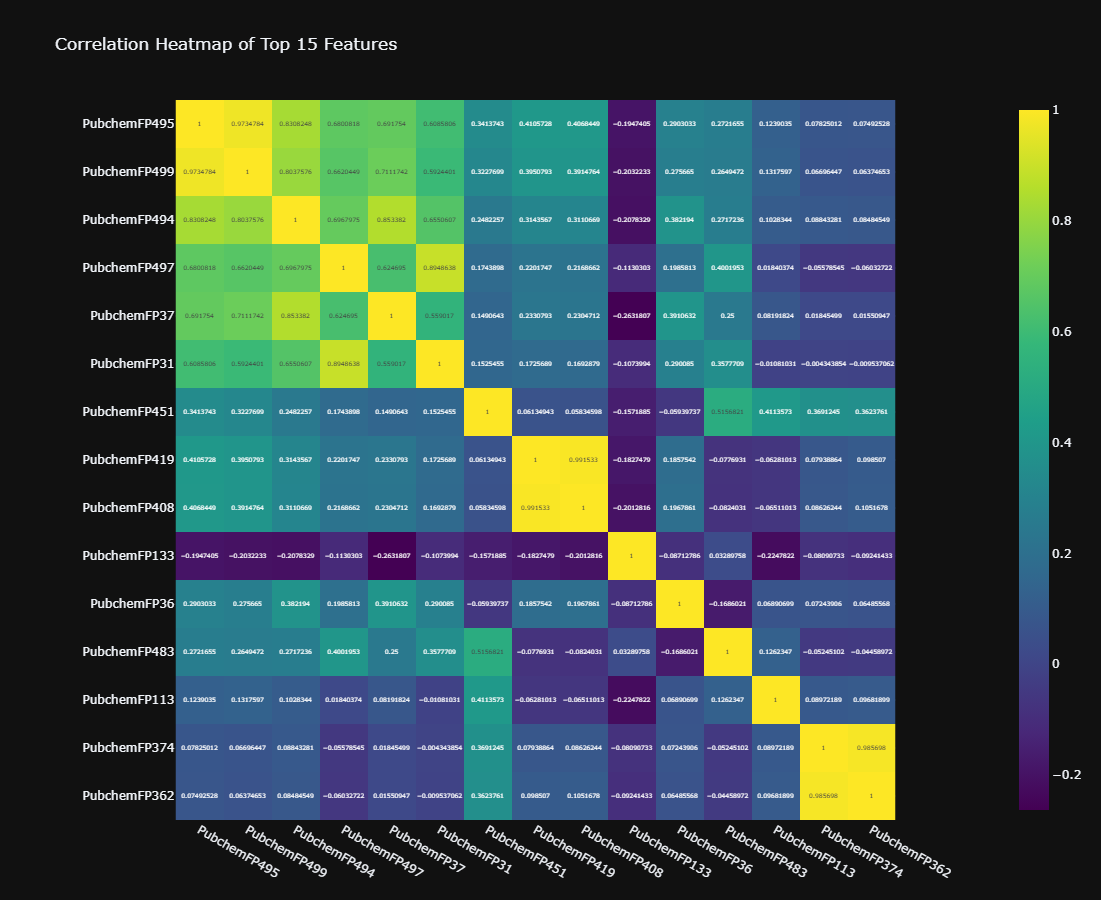

In [131]:

# Correlation heatmap for top features and target
X = df.drop(columns=['PubchemFP501'])  # Exclude the target column
y = df['PubchemFP501']  # Define the target column

# Calculate correlations between features and the target
correlations = X.corrwith(y).abs()

# Select the top 15 features based on correlation
top_15_features = correlations.sort_values(ascending=False).head(15).index.tolist()

# Filter the dataset to include only the top 15 features
X_top_15 = X[top_15_features]

# Create a correlation heatmap
heatmap_data = X_top_15.corr()
fig = px.imshow(
    heatmap_data,
    text_auto=True,
    color_continuous_scale='Viridis',
    title='Correlation Heatmap of Top 15 Features'
)

fig.update_layout(
    height=900,
    width=1100,
    template='plotly_dark'
)

fig.show()


In [100]:
# We save the new dataset
cleaned_dataset.to_csv('new_dataset.csv', index=False)

# **6. Building  models**

In [161]:
df = pd.read_csv('new_dataset.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 425 entries, 0 to 424
Columns: 502 entries, PubchemFP0 to PubchemFP501
dtypes: int64(502)
memory usage: 1.6 MB


In [162]:
df['PubchemFP501'].value_counts()

PubchemFP501
0    413
1     12
Name: count, dtype: int64

# Train-test split 


In [163]:
X_train, X_test, y_train, y_test = train_test_split(X_top_15, y, test_size=0.2, random_state=42)


# Initialize models


In [164]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor

# Updated model definitions with tuned hyperparameters
models = {
    'Random Forest Regressor': RandomForestRegressor(
        n_estimators=100,          # Reduced number of trees
        max_depth=10,              # Limited depth for regularization
        min_samples_split=5,       # Increased minimum samples for splitting
        min_samples_leaf=3,        # Increased minimum samples per leaf
        max_features='sqrt',       # Randomly selecting features for splits
        random_state=42
    ),
    'Support Vector Regressor (SVR)': SVR(
        kernel='rbf',
        C=10,                      # Regularization parameter
        epsilon=0.01               # Tolerance for predictions
    ),
    'k-NN Regressor': KNeighborsRegressor(
        n_neighbors=10,            # Number of neighbors
        weights='uniform'          # Uniform weighting of neighbors
    )
}



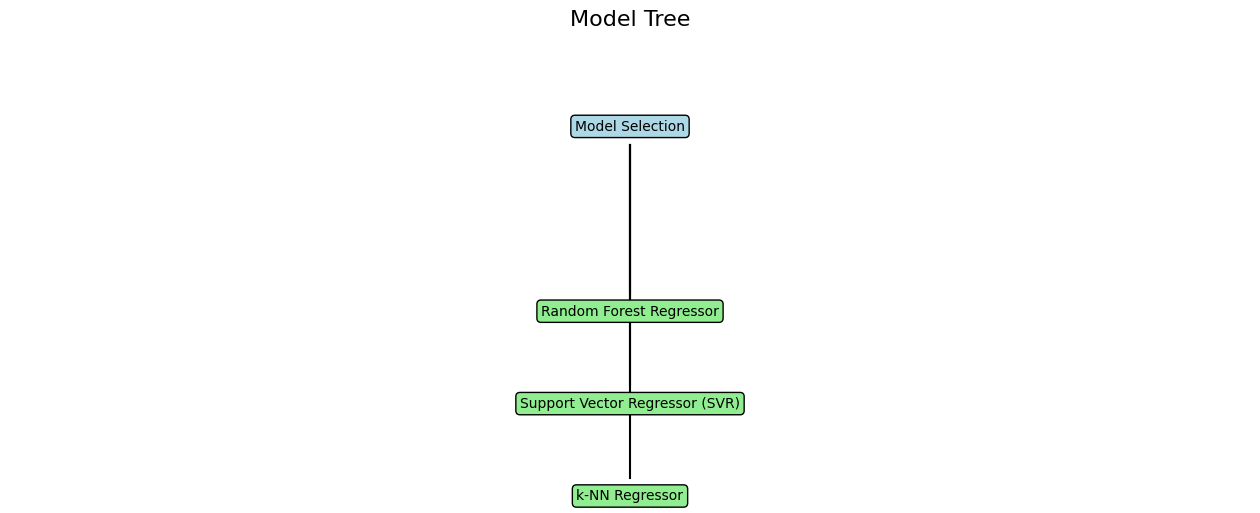

<Figure size 640x480 with 0 Axes>

In [167]:
def visualize_model_tree(models):
    fig, ax = plt.subplots(figsize=(16, 6))
    ax.set_xlim(0, 10)
    ax.set_ylim(0, len(models) + 2)

    # Draw the root node
    ax.text(5, len(models) + 1, 'Model Selection', ha='center', va='center', 
            bbox=dict(boxstyle="round", facecolor="lightblue", edgecolor="black"))

    # Draw child nodes and connect them to the root
    for i, model_name in enumerate(models.keys(), start=1):
        ax.text(5, len(models) - i, model_name, ha='center', va='center', 
                bbox=dict(boxstyle="round", facecolor="lightgreen", edgecolor="black"))
        ax.plot([5, 5], [len(models) + 0.8, len(models) - i + 0.2], color='black')

    # Remove axes
    ax.axis('off')

    plt.title("Model Tree", fontsize=16)
    plt.show()

# Visualize the tree
visualize_model_tree(models)
plt.savefig('model')

# Evaluate models & Fit  & Calculate metrics


In [166]:
# Step 6: Initialize Results List for Evaluation
results = []

for name, model in models.items():
    model.fit(X_train, y_train)
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    # Calculate performance metrics
    mae = mean_absolute_error(y_test, y_test_pred)
    mse = mean_squared_error(y_test, y_test_pred)
    train_r2 = r2_score(y_train, y_train_pred)
    test_r2 = r2_score(y_test, y_test_pred)

    # Append results
    results.append({
        'Model': name,
        'MAE': mae,
        'MSE': mse,
        'Train R²': train_r2,
        'Test R²': test_r2,
    })

# Convert Results to DataFrame and Display
results_df = pd.DataFrame(results)
print("\nModel Evaluation Results:")
print(results_df)



Model Evaluation Results:
                            Model       MAE       MSE  Train R²   Test R²
0         Random Forest Regressor  0.018311  0.004696  0.889442  0.862067
1  Support Vector Regressor (SVR)  0.011085  0.000800  0.997834  0.976500
2                  k-NN Regressor  0.009412  0.003294  0.930379  0.903252
